# Quantum and Semiclassical SearchRank simulation

In this notebook we will show an example of how to calculate the quantum and Semiclassical SearchRank of a sample network using SQUWALS [[1]](https://arxiv.org/abs/2307.14314), our simulator of Szegedy's quantum walks.

**It is recommended to see first the SQUWALS tutorial notebook.**

## Table of Contents

- [Packages](#0)
- [1 - Graph Model and Google Matrix](#1)
- [2 - Classical and Quantum PageRank](#2)
- [3 - Quantum SearchRank](#3)
- [4 - Semiclassical SearchRank](#4)
    - [4.1 - Randomized SearchRank](#4-1)
- [5 - Quantum and Semiclassical SearchRank with our high-level application](#5)
- [6 - Conclusions](#6)
- [7 - References](#7)

<a name='0'></a>
## Packages
First we import the libraries that we need, including our simulator.

In [1]:
import numpy as np
import squwals as sw
import networkx as nx
import random as rd
import matplotlib.pyplot as plt

<a name='1'></a>
## 1 - Graph Model and Google Matrix

We create a scale-free network of $N$ nodes with networkX.

In [2]:
# Number of nodes.
N = 256

# Create a scale-free network with networkX.
graph = nx.scale_free_graph(N,seed=32)

We obtain the transition matrix $H$ of the graph, defined as

$$
H_{i,j} := 
	\left\lbrace\begin{array}{c}
		1/\text{outdeg}(P_j) \ \ \ \text{if} \ P_j \in B_i,\\
		0 \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \text{otherwise},
	\end{array}
	\right.
$$

where $P_j$ refers to node $j$, and $B_i$ is the set of nodes pointing to node $i$. Recall that the nodes are counted from $0$ to $N-1$.

After that, we patch the matrix filling the null columns with $1/N$, obtaining the matrix $E$.

In [3]:
# The transition matrix H is constructed from the traspose of the one given by networkX.
H = nx.to_numpy_array(graph).transpose()

N = H.shape[0]

# Remove multiple edges and normalize the columns of the matrix.
H = np.where(H==0,0.,1.)
sums = sum(H)
for k in range(N):
    if sums[k] != 0:
        H[:,k] = H[:,k]/sums[k]

# Build E from H filling the null columns with 1/N.
E = H.copy()
for k in range(N):
    if sums[k] == 0:
        E[:,k] = E[:,k] + 1/N

We build the Google matrices for the different values of $\alpha$. For the PageRank we use $\alpha = 0.85$, whereas for the SearchRank we use $\alpha = 0.25$.

The Google matrix is constructed as:

$$G = \alpha E + (1-\alpha) I,$$
where $I$ is a matrix where all elements are $1/N$.

In [4]:
alpha_pagerank = 0.85
alpha_searchrank = 0.25

# Build the matrix I where all elements are 1/N.
I = np.ones(N)/N

# Build the Google matrices using E and I.
G_pr = alpha_pagerank*E + (1-alpha_pagerank)*I
G_sr = alpha_searchrank*E + (1-alpha_searchrank)*I

We can also use the built-in function in SQUWALS to obtaing the Google matrix from a networkX graph.

In [5]:
G_pr = sw.build_google_matrix_nx(graph,alpha=0.85)
G_sr = sw.build_google_matrix_nx(graph,alpha=0.25)

We mark some nodes at random, in order to look for them later using the SearchRank algorithm.

In [6]:
# Number of marked nodes.
M = 24

# Create a list with M elements at random.
marked_nodes = []
for k in range(M):
    while True:
        number = rd.randint(0,N-1)
        if number not in marked_nodes:
            marked_nodes.append(number)
            break
marked_nodes.sort()

# Marked nodes for testing.
marked_nodes = [5, 7, 13, 16, 20, 27, 38, 45, 47, 59, 69, 73, 74, 75, 79, 81, 83, 86, 90, 95, 100, 102, 112, 123]

In [7]:
print(marked_nodes)

[5, 7, 13, 16, 20, 27, 38, 45, 47, 59, 69, 73, 74, 75, 79, 81, 83, 86, 90, 95, 100, 102, 112, 123]


<a name='2'></a>
## 2 - Classical and Quantum PageRank

The classical PageRank distribution corresponds to the eigenvector of the Google matrix $G$ with eigenvalue $1$. Due to the form that $G$ is constructed, this eigenvalue is unique and a classical walk converges to it.

To obtain the PageRank distribution without diagonalizing the matrix $G$ we use the power method, so that we apply the matrix $G$ repeteadly to an initial probability distribution until it has converged. This is equivalent to performing a classical walk with $G$ as the transition matrix.

We are going to use our function `classical_walk_simulator` to perform this classical walk.

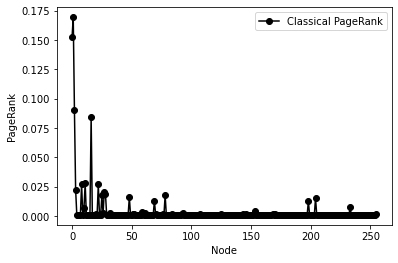

In [8]:
# Create an initial probability distribution. In this case we use the uniform one. It must be a 1D-array.
uniform_distribution = np.ones(N)/N

# Use the classical simulator to perform the classical walk for 50 steps.
"""Args:
    transition_matrix: Column-stochastic transition matrix.
    time_steps: Number of steps of the classical walk.
    initial_distribution: Initial probability distribution of the walker. Default: the uniform one.
"""
classical_distributions = sw.classical_walk_simulator(transition_matrix=G_pr,time_steps=200,initial_distribution=uniform_distribution)

# The result is a bidimensional tensor where the first dimension indicates the time step (including t=0), and the second one the node.
# The classical pagerank corresponds to the distribution at the last time step.
classical_pr = classical_distributions[-1]

plt.plot(classical_pr,'-ok')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.legend(['Classical PageRank'])

The quantum PageRank [[2]](https://www.nature.com/articles/srep00444) can be obtained using the function `quantum_pagerank` of our library.

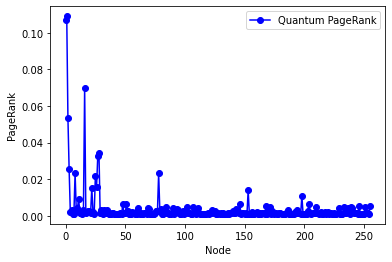

In [9]:
# Apply our function to the Google matrix.

"""
Args:
    google_matrix: Google matrix.
    time_steps: Number of steps of the quantum walk.
"""

results_quantum = sw.quantum_pagerank(G_pr,500)

# The result is an object with three attributes.

"""
Attributes:
    instantaneous: Instantaneous quantum pageranks.
    averaged: Averaged quantum pageranks.
    std: Standard deviations of the averaged quantum pageranks.
"""

# Retrieve the averaged quantum PageRanks.
quantum_pr = results_quantum.averaged

plt.plot(quantum_pr,'-ob')
plt.xlabel('Node')
plt.ylabel('PageRank')
plt.legend(['Quantum PageRank'])

<a name='3'></a>
## 3 - Quantum SearchRank

In this section we show how to use our function `quantum_szegedy_simulator` to obtain the quantum SearchRank [[3]](https://ieeexplore.ieee.org/document/6975444) of the graph. However, our library has a specific high-level application for this algorithm, which is shown in [5 - Quantum and Semiclassical with our high-level application](#5).

The unitary operator used for the quantum SearchRank is

\begin{equation}
	W_Q := SQ_1RSQ_1R,
\end{equation}

where $Q_1$ is the oracle with the marked nodes acting in the first register.

The initial state of the system is chosen to be:

\begin{equation}
	\left|\Psi^{(0)}\right> = \frac{1}{\sqrt{N}}\sum_{i=0}^{N-1}\left|\psi_i\right>,
\end{equation}

The position of the walker after the quantum evolution is described by the register $2$ of the quantum state, so the projection onto the computational basis of the second register will give us the quantum SearchRanks for each node:

\begin{equation}
	S_q(P_i,t) := ||_2{\left<i\right|W_Q^t\left|\Psi^{0}\right>}{}||^2.
\end{equation}

where $P_i$ is a concrete node, and $t$ the time step.

As a reference time, we will take the distribution at $t = \left\lfloor\sqrt{N/M}\right\rceil$ as the SearchRank [[4]](https://arxiv.org/abs/2401.01554).

First, we create the operators that will form the unitary.

In [10]:
# Swap operator.
S = sw.Swap()

# Reflection operator with the Google matrix for the SearchRank.
R = sw.Reflection(G_sr)

# Oracle in the first register.
Q = sw.Oracle(register=1,marked_nodes=marked_nodes)

Now we use these building blocks to construct the unitary operator $W_Q$. Note that when using the `Unitary` class, the first operator in the list is the first acting over the quantum state. In this case it is the reflection $R$.

In [11]:
# Using the unitary class.

# W = sw.Unitary([R,Q,S,R,Q,S])

# Mutiplying operators in an algebraic sense.

W = S * Q * R * S * Q * R

W.info()

Custom unitary:
 1 - Reflection
 2 - Oracle: Register 1: nodes [5, 7, 13, 16, 20, 27, 38, 45, 47, 59, 69, 73, 74, 75, 79, 81, 83, 86, 90, 95, 100, 102, 112, 123]
 3 - Swap
 4 - Reflection
 5 - Oracle: Register 1: nodes [5, 7, 13, 16, 20, 27, 38, 45, 47, 59, 69, 73, 74, 75, 79, 81, 83, 86, 90, 95, 100, 102, 112, 123]
 6 - Swap


Now we simulate the quantum walk to obtain the quantum distributions at each time step.

In [12]:
# Create the initial state from the Google matrix.
initial_state = sw.create_initial_state(G_sr)

# We do the simulation for 50 steps.
time_steps = 50

# We use the unitary operator W, and measure in the second register.

instantaneous_quantum_searchrank = sw.quantum_szegedy_simulator(unitary=W,initial_state=initial_state,time_steps=time_steps,measure=2)

# The result is a bidimensional tensor where the first dimension indicates the time step (including t=0), and the second one the node.

In order to obtain the probability curve of measuring a marked node we sum the probability of the marked nodes.

In [13]:
quantum_probabilities = np.sum(instantaneous_quantum_searchrank[:,marked_nodes],axis=1)

We plot the probability, and look at the reference time which we use to obtain the SearchRank distribution.

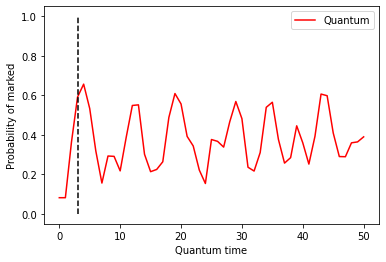

In [14]:
ref_time = int(np.round(np.sqrt(N/M)))

times = np.arange(len(quantum_probabilities))
plt.plot(times,quantum_probabilities,'r')
plt.xlabel('Quantum time')
plt.ylabel('Probability of marked')
plt.plot([ref_time,ref_time],[0,1],'--k')
plt.legend(['Quantum'],loc=1)
plt.show()

Let us take the quantum SearchRank at the reference time.

In [15]:
quantum_searchrank = instantaneous_quantum_searchrank[ref_time]

We compare the quantum SearchRank with the classical and quantum PageRanks. Since the SearchRank is obtained by amplifying the probability of the marked nodes, we use different scales.

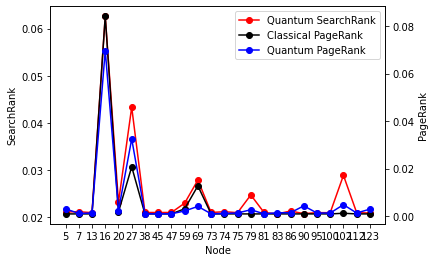

In [16]:
ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
ax1.plot(quantum_searchrank[marked_nodes],'-or',label='Quantum SearchRank')
ax2.plot(classical_pr[marked_nodes],'-ok',label='Classical PageRank')
ax2.plot(quantum_pr[marked_nodes],'-ob',label='Quantum PageRank')
plt.xticks(ticks=range(len(marked_nodes)),labels=marked_nodes)
ax1.set_xlabel('Node')
ax1.set_ylabel('SearchRank')
ax2.set_ylabel('PageRank')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)
plt.show()

<a name='4'></a>
## 4 - Semiclassical SearchRank

In order to obtain the Semiclassical SearchRank [[4]](https://arxiv.org/abs/2401.01554), we have to simulate the semiclassical transition matrices [[5]](https://www.sciencedirect.com/science/article/pii/S0378437123005769) using the semiclassical Szegedy simulator with the marked nodes. These matrices are defined as follows:

\begin{equation}
	_2{G}{}^{(t_q)}_{ji} := \left|\left|_2{\left<j\right|W_Q^{t_q}\left|\psi_i\right>}{}\right|\right|^2,
\end{equation}

where $t_q$ is the quantum time of the semiclassical walk, and the left subindex $2$ indicates that we are measuring the second register. 

In [17]:
# We do the simulation for 50 quantum time steps.
time_steps = 50
# We use the unitary operator W, and measure in the second register.
semiclassical_matrices = sw.semiclassical_szegedy_simulator(transition_matrix=G_sr,time_steps=time_steps,unitary=W,batch_size=64,measure=2)

Number of simulated nodes =  0
Epoch =  1 , Current nodes = 1 - 64
-------------------------
Number of simulated nodes =  64
Epoch =  2 , Current nodes = 65 - 128
-------------------------
Number of simulated nodes =  128
Epoch =  3 , Current nodes = 129 - 192
-------------------------
Number of simulated nodes =  192
Epoch =  4 , Current nodes = 193 - 256
-------------------------
Number of simulated nodes =  256


The result of our semiclassical simulator is a 3D tensor, where the first dimension indicates the quantum time (including $t_q=0$), and the other two correspond to the matrices dimensions.

Each of these matrices will give an instantaneous Semiclassical SearchRank distribution if we perform a classical walk until it converges.

In [18]:
# Create the initial probability distribution.
uniform_distribution = np.ones(N)/N

# Create a 2D tensor to store the instantaneous Semiclassical SearchRanks.

instantaneous_semiclassical_searchrank = np.zeros([time_steps+1,N])

# Perform the classical walk with the semiclassical matrices and store the results.

for k in range(time_steps+1):
    semiclassical_distributions = sw.classical_walk_simulator(semiclassical_matrices[k],time_steps=200)
    instantaneous_semiclassical_searchrank[k] = semiclassical_distributions[-1]

We obtain the probability curve and plot the Semiclassical SearchRank distribution at the reference time.

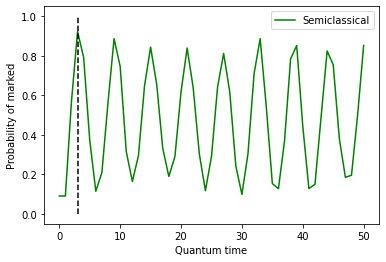

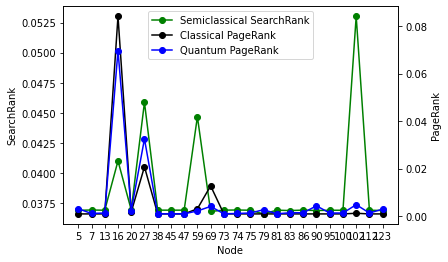

In [19]:
semiclassical_probabilities = np.sum(instantaneous_semiclassical_searchrank[:,marked_nodes],axis=1)

ref_time = int(np.round(np.sqrt(N/M)))

times = np.arange(len(semiclassical_probabilities))
plt.plot(times,semiclassical_probabilities,'g')
plt.xlabel('Quantum time')
plt.ylabel('Probability of marked')
plt.plot([ref_time,ref_time],[0,1],'--k')
plt.legend(['Semiclassical'],loc=1)
plt.show()

semiclassical_searchrank = instantaneous_semiclassical_searchrank[ref_time]

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
ax1.plot(semiclassical_searchrank[marked_nodes],'-og',label='Semiclassical SearchRank')
ax2.plot(classical_pr[marked_nodes],'-ok',label='Classical PageRank')
ax2.plot(quantum_pr[marked_nodes],'-ob',label='Quantum PageRank')
plt.xticks(ticks=range(len(marked_nodes)),labels=marked_nodes)
ax1.set_xlabel('Node')
ax1.set_ylabel('SearchRank')
ax2.set_ylabel('PageRank')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2,loc=9)
plt.show()

<a name='4-1'></a>
### 4.1 - Randomized Semiclassical SearchRank

The Randomized SearchRank [[4]](https://arxiv.org/abs/2401.01554) is a simplified version of the Semiclassical SearchRank. It is obtained performing only one step during the classical walk with the semiclassical matrices.

In [20]:
# Create the initial probability distribution.
uniform_distribution = np.ones(N)/N

# Create a 2D tensor to store the instantaneous Randomized SearchRanks.

instantaneous_randomized_searchrank = np.zeros([time_steps+1,N])

# Perform the classical walk with the semiclassical matrices and store the results.

for k in range(time_steps+1):
    randomized_distributions = sw.classical_walk_simulator(semiclassical_matrices[k],time_steps=1)
    instantaneous_randomized_searchrank[k] = randomized_distributions[-1]

We obtain the probability curve and plot the SearchRank distribution at the reference time.

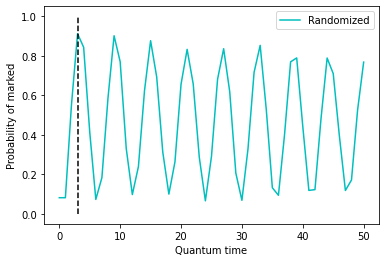

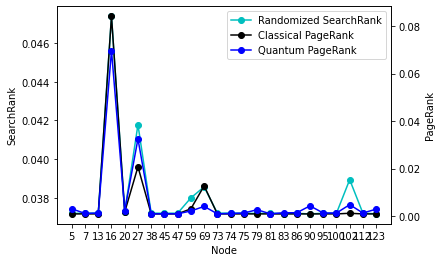

In [21]:
randomized_probabilities = np.sum(instantaneous_randomized_searchrank[:,marked_nodes],axis=1)

ref_time = int(np.round(np.sqrt(N/M)))

times = np.arange(len(randomized_probabilities))
plt.plot(times,randomized_probabilities,'c')
plt.xlabel('Quantum time')
plt.ylabel('Probability of marked')
plt.plot([ref_time,ref_time],[0,1],'--k')
plt.legend(['Randomized'],loc=1)
plt.show()

randomized_searchrank = instantaneous_randomized_searchrank[ref_time]

ax1 = plt.subplot(1,1,1)
ax2 = ax1.twinx()
ax1.plot(randomized_searchrank[marked_nodes],'-oc',label='Randomized SearchRank')
ax2.plot(classical_pr[marked_nodes],'-ok',label='Classical PageRank')
ax2.plot(quantum_pr[marked_nodes],'-ob',label='Quantum PageRank')
plt.xticks(ticks=range(len(marked_nodes)),labels=marked_nodes)
ax1.set_xlabel('Node')
ax1.set_ylabel('SearchRank')
ax2.set_ylabel('PageRank')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)
plt.show()

<a name='5'></a>
## 5 - Quantum and Semiclassical SearchRank with our high-level application

We can use our high-level applications for SearchRank simulation in order to obtain the same results than above but with fewer lines of code.

For the quantum SearchRank we have the function `quantum_searchrank`. The arguments are the following:

- google_matrix: Column-stochastic transition matrix.
- time_steps: Number of steps of the quantum walk.
- marked_nodes: A list with the nodes to mark.

In [22]:
quantum_results = sw.quantum_searchrank(google_matrix=G_sr,time_steps=50,marked_nodes=marked_nodes)

instantaneous_quantum_searchrank = quantum_results.instantaneous_quantum_searchrank
quantum_probabilities = quantum_results.quantum_probabilities
quantum_searchrank = quantum_results.quantum_searchrank

For the Semiclassical SearchRank we have the function `semiclassical_searchrank`. This function calculates both the Semiclassical and the Randomized SearchRanks. The arguments are the following:

- google_matrix: Column-stochastic transition matrix.
- quantum_time_steps: Number of quantum time steps of the semiclassical walk.
- marked_nodes: A list with the nodes to mark.
- batch_size: Number of states being vectorized at a batch.
- classical_time_steps: Number of classical time steps of the semiclassical walk.
- monitor: If True, the number of current simulated states is printed.

In [23]:
semiclassical_results = sw.semiclassical_searchrank(google_matrix=G_sr,quantum_time_steps=50,marked_nodes=marked_nodes,batch_size=64,classical_time_steps=200,monitor=True)

semiclassical_matrices = semiclassical_results.semiclassical_matrices

instantaneous_semiclassical_searchrank = semiclassical_results.instantaneous_semiclassical_searchrank
semiclassical_probabilities = semiclassical_results.semiclassical_probabilities
semiclassical_searchrank = semiclassical_results.semiclassical_searchrank

instantaneous_randomized_searchrank = semiclassical_results.instantaneous_randomized_searchrank
randomized_probabilities = semiclassical_results.randomized_probabilities
randomized_searchrank = semiclassical_results.randomized_searchrank

Number of simulated nodes =  0
Epoch =  1 , Current nodes = 1 - 64
-------------------------
Number of simulated nodes =  64
Epoch =  2 , Current nodes = 65 - 128
-------------------------
Number of simulated nodes =  128
Epoch =  3 , Current nodes = 129 - 192
-------------------------
Number of simulated nodes =  192
Epoch =  4 , Current nodes = 193 - 256
-------------------------
Number of simulated nodes =  256


Finally, let us plot the results toguether.

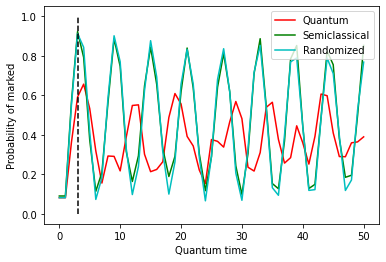

In [24]:
times = np.arange(len(randomized_probabilities))
plt.plot(times,quantum_probabilities,'r')
plt.plot(times,semiclassical_probabilities,'g')
plt.plot(times,randomized_probabilities,'c')
plt.xlabel('Quantum time')
plt.ylabel('Probability of marked')
plt.plot([ref_time,ref_time],[0,1],'--k')
plt.legend(['Quantum','Semiclassical','Randomized'],loc=1)
plt.show()

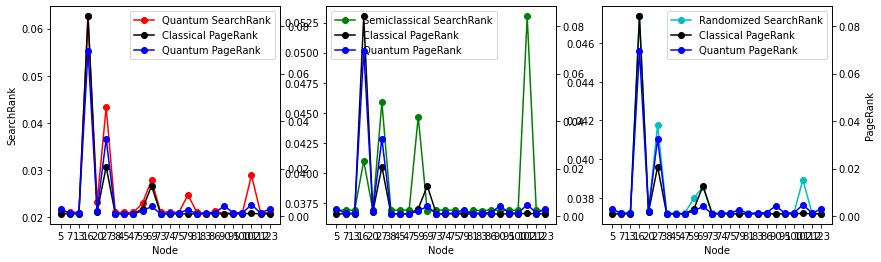

In [25]:
plt.figure(figsize=(14,4))

ax1 = plt.subplot(1,3,1)
ax2 = ax1.twinx()
ax1.plot(quantum_searchrank[marked_nodes],'-or',label='Quantum SearchRank')
ax2.plot(classical_pr[marked_nodes],'-ok',label='Classical PageRank')
ax2.plot(quantum_pr[marked_nodes],'-ob',label='Quantum PageRank')
plt.xticks(ticks=range(len(marked_nodes)),labels=marked_nodes)
ax1.set_xlabel('Node')
ax1.set_ylabel('SearchRank')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

ax1 = plt.subplot(1,3,2)
ax2 = ax1.twinx()
ax1.plot(semiclassical_searchrank[marked_nodes],'-og',label='Semiclassical SearchRank')
ax2.plot(classical_pr[marked_nodes],'-ok',label='Classical PageRank')
ax2.plot(quantum_pr[marked_nodes],'-ob',label='Quantum PageRank')
plt.xticks(ticks=range(len(marked_nodes)),labels=marked_nodes)
ax1.set_xlabel('Node')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

ax1 = plt.subplot(1,3,3)
ax2 = ax1.twinx()
ax1.plot(randomized_searchrank[marked_nodes],'-oc',label='Randomized SearchRank')
ax2.plot(classical_pr[marked_nodes],'-ok',label='Classical PageRank')
ax2.plot(quantum_pr[marked_nodes],'-ob',label='Quantum PageRank')
plt.xticks(ticks=range(len(marked_nodes)),labels=marked_nodes)
ax1.set_xlabel('Node')
ax2.set_ylabel('PageRank')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2)

plt.show()

<a name='6'></a>
## 6 - Conclusions

We have shown an example of how to use our Szegedy quantum and semiclassical walks simulator to calculate the SearchRank distributions of a scale-free network.

Moreover, we have also seen how to use our hihg-level applications directly for that purpose.

<a name='7'></a>
## 7 - References

- [1] **[S. A. Ortega and M. A. Martin-Delgado. SQUWALS: A Szegedy QUantum WALks Simulator. arXiv:2307.14314.](https://arxiv.org/abs/2307.14314)**
- [2] **[G. D. Paparo and M. A. Martin-Delgado. Google in a Quantum Network. Scientific Reports, 2:444, 2012.](https://www.nature.com/articles/srep00444)**
- [3] **[H. Wang, J. Wu, X. Yang, P. Chen, and X. Yi. An Enhanced Quantum PageRank Algorithm Integrated with Quantum Search. 2014 Eighth International Conference on Innovative Mobile and Internet Services in Ubiquious Computing, IEEE:74–81, 2014.](https://ieeexplore.ieee.org/document/6975444)**
- [4] **[S. A. Ortega and M. A. Martin-Delgado. Randomized SearchRank: A Semiclassical Approach to a Quantum Search Engine. arXiv:2401.01554.](https://arxiv.org/abs/2401.01554)**
- [5] **[S. A Ortega and M. A. Martin-Delgado. Discrete-time Semiclassical Szegedy Quantum Walks. Physica A, 625:129021, 2023.](https://www.sciencedirect.com/science/article/pii/S0378437123005769)**